# Swin Factorizer for Stroke Lesion Segmentation

## Setup environment

Clone the repository and install the dependencies:

In [ ]:
!git clone https://github.com/pashtari/factorizer-isles22.git
!pip install -r requirements.txt

## Setup imports

In [1]:
import os

import numpy as np
import torch
from torch import nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
import pytorch_lightning as pl
from monai import transforms
from monai.data import Dataset, DataLoader
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric
from monai.inferers import SlidingWindowInferer
import SimpleITK as sitk
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap


import factorizer as ft


/Users/pooya/opt/miniconda3/envs/isles/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set Deterministic Training for Reproducibility

In [2]:
pl.seed_everything(42, workers=True)
torch.set_default_dtype(torch.float32)


Global seed set to 42


## Prepare Data 

Before proceeding, download the official ISLES'22 dataset from [this link](https://isles22.grand-challenge.org/). Then, place [`datalist.json`](datalist.json) in the dataset folder to get the following structure:

```bash
<dataset_dir>
├── datalist.json # <--
├── dataset_description.json
├── LICENSE
├── participants.tsv
├── README
├── derivatives
│   ├── sub-strokecase0001
│   ├── sub-strokecase0002
│   └── ...
├── sub-strokecase0001
├── sub-strokecase0002
└── ...
```

The ISLES dataset comes with 3 modalities, namely DWI, ADC, and FLAIR along with the ground truth, which is manually obtained by multiple raters. The important point here is that DWI and ADC are aligned with each other but not with FLAIR. Therefore, as a preprocessing step, we first need to register FLAIR to the DWI space so the concatenation of these modalities makes sense. We use [SimpleElastix](https://simpleelastix.github.io/) to register FLAIR to DWI co-registration:

In [3]:
dataset_dir = "/Volumes/T7/data/ISLES22"
for i in range(1, 251):
    id_ = f"sub-strokecase{i:04d}"
    print(f"id: {id_} done.")

    dwi_path = os.path.join(
        dataset_dir, f"{id_}/ses-0001/dwi/{id_}_ses-0001_DWI.nii.gz"
    )
    fixed_image = sitk.ReadImage(dwi_path)

    flair_path = os.path.join(
        dataset_dir,
        f"{id_}/ses-0001/anat/{id_}_ses-0001_FLAIR.nii.gz",
    )
    moving_image = sitk.ReadImage(flair_path)

    registered_image = sitk.Elastix(fixed_image, moving_image)
    flair_registered_path = os.path.join(
        dataset_dir,
        f"{id_}/ses-0001/anat/{id_}_ses-0001_FLAIR_registered.nii.gz",
    )
    assert fixed_image.GetSize() == registered_image.GetSize()
    sitk.WriteImage(registered_image, flair_registered_path)


id: sub-strokecase0001 done.
id: sub-strokecase0002 done.
id: sub-strokecase0003 done.
id: sub-strokecase0004 done.
id: sub-strokecase0005 done.
id: sub-strokecase0006 done.
id: sub-strokecase0007 done.
id: sub-strokecase0008 done.
id: sub-strokecase0009 done.
id: sub-strokecase0010 done.
id: sub-strokecase0011 done.
id: sub-strokecase0012 done.
id: sub-strokecase0013 done.
id: sub-strokecase0014 done.
id: sub-strokecase0015 done.
id: sub-strokecase0016 done.
id: sub-strokecase0017 done.
id: sub-strokecase0018 done.
id: sub-strokecase0019 done.
id: sub-strokecase0020 done.
id: sub-strokecase0021 done.
id: sub-strokecase0022 done.
id: sub-strokecase0023 done.
id: sub-strokecase0024 done.
id: sub-strokecase0025 done.
id: sub-strokecase0026 done.
id: sub-strokecase0027 done.
id: sub-strokecase0028 done.
id: sub-strokecase0029 done.
id: sub-strokecase0030 done.
id: sub-strokecase0031 done.
id: sub-strokecase0032 done.
id: sub-strokecase0033 done.
id: sub-strokecase0034 done.
id: sub-stroke

After running above, for each patient, the FLAIR image registered to the DWI space is saved as a file named `{id}_ses-0001_FLAIR_registered.nii.gz` in `{id}/ses-0001/anat`.

## Check Image Shape and Visualize

image shape: (3, 112, 112, 73)
mask shape: (1, 112, 112, 73)


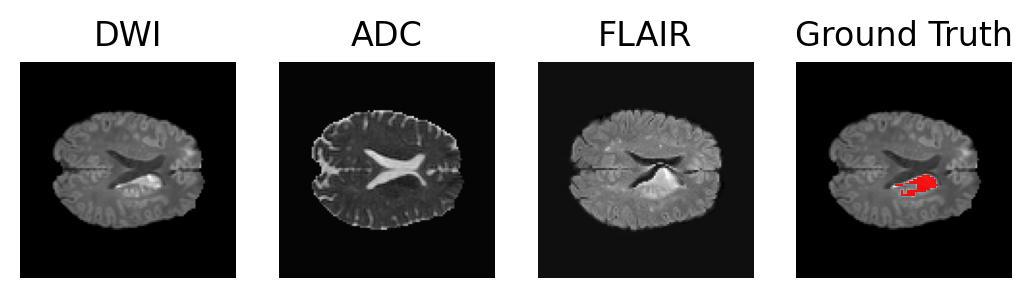

In [4]:
# set data path and
dataset_dir = "/Volumes/T7/data/ISLES22"

# set patient ID and images path
id_ = "sub-strokecase0052"
dwi_path = f"{dataset_dir}/{id_}/ses-0001/dwi/{id_}_ses-0001_dwi.nii.gz"
adc_path = f"{dataset_dir}/{id_}/ses-0001/dwi/{id_}_ses-0001_adc.nii.gz"
flair_path = f"{dataset_dir}/{id_}/ses-0001/anat/{id_}_ses-0001_FLAIR_registered.nii.gz"
msk_path = f"{dataset_dir}/derivatives/{id_}/ses-0001/{id_}_ses-0001_msk.nii.gz"

# make data dictionary
data = {
    "image": [dwi_path, adc_path, flair_path],
    "mask": msk_path,
}

load_image = transforms.LoadImaged(
    ["image", "mask"],
    ensure_channel_first=True,
    allow_missing_keys=True,
)

# load image data
data = load_image(data)
print(f"image shape: {data['image'].shape}")
print(f"mask shape: {data['mask'].shape}")


dwi_image = data["image"][0]
adc_image = data["image"][1]
flair_image = data["image"][2]
msk_image = data["mask"][0]

# pick a slice with the largest lesion volume for visualization
slc = msk_image.sum((0, 1)).argmax()

fig, ax = plt.subplots(1, 4, dpi=200)
# visulize DWI image
ax[0].imshow(dwi_image[:, :, slc], cmap="gray", origin="lower")
ax[0].set_title("DWI")
ax[0].set_axis_off()

# visulize ADC image
ax[1].imshow(adc_image[:, :, slc], cmap="gray", origin="lower")
ax[1].set_title("ADC")
ax[1].set_axis_off()

# visulize the registered FLAIR image
ax[2].imshow(flair_image[:, :, slc], cmap="gray", origin="lower")
ax[2].set_title("FLAIR")
ax[2].set_axis_off()

# visulize mask
ax[3].imshow(dwi_image[:, :, slc], "gray", origin="lower")
masked = np.ma.masked_where(msk_image[:, :, slc] == 0, dwi_image[:, :, slc])
ax[3].imshow(masked, ListedColormap(["red"]), alpha=0.9, origin="lower")
ax[3].set_title("Ground Truth")
ax[3].set_axis_off()

## Setup Transforms for Training and Validation

In [5]:
def get_train_transform():
    train_transform = [
        ft.ReadImaged(["image", "label"], ensure_channel_first=True),
        transforms.SqueezeDimd("image", dim=1),
        transforms.CropForegroundd(["image", "label"], source_key="image"),
        transforms.NormalizeIntensityd("image", nonzero=True, channel_wise=True),
        transforms.Spacingd(
            ["image", "label"],
            pixdim=(2.0, 2.0, 2.0),
            mode=("bilinear", "bilinear"),
        ),
        transforms.RandSpatialCropd(
            ["image", "label"], roi_size=(64, 64, 64), random_size=False
        ),
        transforms.RandAffined(
            ["image", "label"],
            prob=0.15,
            spatial_size=(64, 64, 64),
            rotate_range=[30 * np.pi / 180] * 3,
            scale_range=[0.3] * 3,
            mode=("bilinear", "bilinear"),
            as_tensor_output=False,
        ),
        transforms.RandFlipd(["image", "label"], prob=0.5, spatial_axis=0),
        transforms.RandFlipd(["image", "label"], prob=0.5, spatial_axis=1),
        transforms.RandFlipd(["image", "label"], prob=0.5, spatial_axis=2),
        transforms.RandGaussianNoised("image", prob=0.15, std=0.1),
        transforms.RandGaussianSmoothd(
            "image",
            prob=0.15,
            sigma_x=(0.5, 1.5),
            sigma_y=(0.5, 1.5),
            sigma_z=(0.5, 1.5),
        ),
        transforms.RandScaleIntensityd("image", prob=0.15, factors=0.3),
        transforms.RandShiftIntensityd("image", prob=0.15, offsets=0.1),
        transforms.RandAdjustContrastd("image", prob=0.15, gamma=(0.7, 1.5)),
        transforms.AsDiscreted("label", threshold=0.5),
        transforms.ToTensord(["image", "label"]),
    ]
    train_transform = transforms.Compose(train_transform)
    return train_transform


def get_val_transform():
    val_transform = [
        ft.ReadImaged(
            ["image", "label"], ensure_channel_first=True, allow_missing_keys=True
        ),
        transforms.SqueezeDimd("image", dim=1),
        transforms.NormalizeIntensityd("image", nonzero=True, channel_wise=True),
        transforms.ToTensord(["image", "label"], allow_missing_keys=True),
    ]
    val_transform = transforms.Compose(val_transform)
    return val_transform


## Create Lightning Data Module

In [6]:
class ISLESDataModule(pl.LightningDataModule):
    def __init__(
        self,
        data_properties,
        fold=0,
        batch_size=2,
        num_workers=None,
        **kwargs,
    ):
        super().__init__()
        
        self.data_properties = ft.load_properties(data_properties)
        self.fold = fold
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.dataset_kwargs = kwargs

        self.train_transform = get_train_transform()
        self.val_transform = get_val_transform()
        self.test_transform = get_val_transform()

        self.train_set = self.val_set = self.test_set = None
    
    def setup(self, stage=None):
        if stage in ("fit", "validate", None):
            # make training set
            training_data = []
            val_data = []
            for sample in self.data_properties["training"]:
                if sample["fold"] == self.fold:
                    val_data.append(sample)
                else:
                    training_data.append(sample)

            self.train_set = Dataset(
                training_data,
                transform=self.train_transform,
                **self.dataset_kwargs,
            )
            self.val_set = Dataset(
                val_data,
                transform=self.val_transform,
                **self.dataset_kwargs,
            )

        if stage in ("test", "predict", None):
            # make test set
            self.test_set = Dataset(
                self.data_properties["test"],
                transform=self.test_transform,
                **self.dataset_kwargs,
            )

    def train_dataloader(self):
        train_loader = DataLoader(
            self.train_set,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=torch.cuda.is_available(),
        )
        return train_loader

    def val_dataloader(self):
        val_loader = DataLoader(
            self.val_set,
            batch_size=1,
            num_workers=self.num_workers,
        )
        return val_loader

    def test_dataloader(self):
        test_loader = DataLoader(
            self.test_set,
            batch_size=1,
            num_workers=self.num_workers,
        )
        return test_loader


## Quickly Check Data Module

In [7]:
dm = ISLESDataModule(
    data_properties="/Volumes/T7/data/ISLES22/datalist.json",
    fold=0,
    batch_size=2,
    num_workers=4,
)
dm.setup()
val_ds = dm.val_set[2]

print(f"image shape: {val_ds['image'].shape}")
print(f"mask shape: {val_ds['label'].shape}")


image shape: torch.Size([3, 112, 112, 73])
mask shape: torch.Size([1, 112, 112, 73])


## Create Lightning Module 

In [8]:
class SwinFactorizer(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.net = ft.SegmentationFactorizer(
            in_channels=3,
            out_channels=1,
            spatial_size=(64, 64, 64),
            encoder_depth=[1, 1, 1, 1, 1],
            encoder_width=[32, 64, 128, 256, 512],
            strides=[1, 2, 2, 2, 2],
            decoder_depth=[1, 1, 1, 1],
            stem=[nn.Conv3d, {"kernel_size": 3, "padding": 1, "bias": False}],
            downsample=[nn.Conv3d, {"kernel_size": 2, "bias": False}],
            upsample=[nn.ConvTranspose3d, {"kernel_size": 2}],
            head=[nn.Conv3d, {"kernel_size": 1}],
            dropout=0.1,
            nmf=(
                ft.FactorizerSubblock,
                {
                    "tensorize": (
                        ft.SWMatricize,
                        {
                            "head_dim": 8,
                            "patch_size": 4,
                            "shifts": [None, 1, 2, 3],
                        },
                    ),
                    "act": nn.ReLU,
                    "factorize": ft.NMF,
                    "rank": 1,
                    "num_iters": 5,
                    "num_grad_steps": None,
                    "init": "uniform",
                    "solver": "hals",
                    "dropout": 0.1,
                },
            ),
            mlp=(ft.MLP, {"ratio": 2, "dropout": 0.1}),
        )
        self.loss = DiceCELoss(sigmoid=True, squared_pred=True)
        self.dice_metric = DiceMetric(reduction="mean_batch", get_not_nans=True)
        self.max_epochs = 500
        self.inferer = SlidingWindowInferer(
            roi_size=(64, 64, 64), sw_batch_size=1, overlap=0.5
        )
        self.post = transforms.Compose(
            transforms.Activations(sigmoid=True), transforms.AsDiscrete(threshold=0.5)
        )

    def num_parameters(self):
        return sum(p.numel() for p in self.net.parameters() if p.requires_grad)

    def forward(self, x):
        out = self.net(x)[0]
        return out

    def configure_optimizers(self):
        optimizer = AdamW(self.net.parameters(), lr=0.0001, weight_decay=0.01)
        scheduler = CosineAnnealingLR(optimizer, T_max=self.max_epochs)
        return [optimizer], [scheduler]

    def predict_step(self, batch, batch_idx):
        x = batch["image"]
        y_hat = self.inferer(x, self)
        y_hat = self.post(y_hat)
        return y_hat

    def training_step(self, batch, batch_idx):
        x, y = batch["image"], batch["label"]
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        y = batch["label"]
        y_hat = self.predict_step(batch, batch_idx)
        val_dice = self.dice_metric(y_hat, y)
        return {"val_dice": val_dice}

    def validation_epoch_end(self, val_outputs):
        mean_val_dice, _ = self.dice_metric.aggregate()
        self.log("val_dice", mean_val_dice, prog_bar=True)
        self.dice_metric.reset()



## Run the Training

In [ ]:
# initialize data module
dm = ISLESDataModule(
    data_properties="/Volumes/T7/data/ISLES22/datalist.json",
    fold=0,
    batch_size=1,
    num_workers=4,
)

# initialize lightning module
model = SwinFactorizer()

# setup loggers and checkpoints
tb_logger = pl.loggers.TensorBoardLogger(save_dir="./logs", name="swin-factorizer")

# initialize Lightning's trainer.
trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    max_epochs=500,
    logger=tb_logger,
    check_val_every_n_epoch=5,
)

# train
trainer.fit(model, dm)
print(f"Train completed, Dice: {model.val_dice:.3f}")


## Monitor Training in Tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=logs